This tool aims to study the QTL disequilibrium within the duplicated apple genome.



In [1]:
##############################################################################
# Import needed modules and packages
##############################################################################

import ipywidgets as widgets
import numpy as np
import pandas as pd
from IPython.display import display
from ipywidgets import interact

from lib.config_parser import config_parser
from lib.misc import (delete_temporary_files, description_of_datasets,
                      output_dataframe_in_csv)
from lib.statistical_functions import (
    compute_verbose_binomial_test, compute_verbose_mcnemar_test,
    compute_verbose_proportions_chisquare, compute_verbose_proportions_ztest)
from lib.visualization import generate_visualizations
from lib.whole_chromosomes import compute_all_tests
import os


In [2]:
# Load configuration
conf = config_parser('./conf/config_statistical_exploration.yaml')
##############################################################################
# Load datasets and initialize some variables
##############################################################################
# Read input files and put it in pandas Data Frame
# QTL related files
allQtlPhysicalyMappedDf = pd.read_csv(conf['QTL']['AllQtlPhysicalyMappedDf'], compression='infer')
allQtlDf = pd.read_csv(conf['QTL']['AllQtlDf'], compression='infer')
# Markers and physical location related files
chromosomeData = pd.read_csv(conf['SynthenicBlocks']['chromosomeData'])
mappedMarkers = pd.read_csv(conf['Markers']['mappedMarkers'], compression='infer')
# Synthenic blocks
syntenicBlocksDf = pd.read_csv(conf['SynthenicBlocks']['synthenicBlocks'])
# Variable initialization
verbose = conf['Variable']['verbose']
outputAsFile = conf['Variable']['outputAsFile']

# Result outputed files
# Tables
outputPathAllQtlPhysicalyMappedDf = conf['Statistics'][
    'outputPathAllQtlPhysicalyMappedDf']
outputPathAllQtlDf = conf['Statistics']['outputPathAllQtlDf']
outputPathStatsVanilla = conf['Statistics']['outputPathStatsVanilla']
outputPathSatsR2Effect = conf['Statistics']['outputPathSatsR2Effect']
outputPathAllOriginEffect = conf['Statistics']['outputPathAllOriginEffect']
outputPathCategoryEffect = conf['Statistics']['outputPathCategoryEffect']
outputPathTraitCategoryLevel2Effect = conf['Statistics'][
    'outputPathTraitCategoryLevel2Effect']
outputPathTraitCategoryLevel3Effect = conf['Statistics'][
    'outputPathTraitCategoryLevel3Effect']
# Figure
outputPathStripplotWithLimits = conf['Figure']['outputPathStripplotWithLimits']
outputPathStripplotWithPositions = conf['Figure'][
    'outputPathStripplotWithPositions']

# Recreate file architecture if needed
for name in conf['Figure']:
  os.makedirs(os.path.dirname(conf['Figure'][name]), exist_ok=True)

descriptionOfDatasetsAllQtlPhysicalyMappedDf = description_of_datasets(
    allQtlPhysicalyMappedDf)
descriptionOfDatasetsAllQtlDf = description_of_datasets(allQtlDf)

display(descriptionOfDatasetsAllQtlPhysicalyMappedDf)


SSR  SNP Non_Mapped Mapped Total
Chromosome_Number                                  
1                    6   28          0     37    37
2                   10   23          0     34    34
3                    8   36          0     47    47
4                    4   11          0     15    15
5                   19   22          0     42    42
6                   15    7          0     23    23
7                    2    7          0      9     9
8                   13    9          0     22    22
9                    4   19          0     26    26
10                  15   25          0     41    41
11                  12   19          0     31    31
12                  10   19          0     31    31
13                   4   19          0     25    25
14                   6   30          0     36    36
15                  17   23          0     43    43
16                  18   30          0     49    49
17                  13   14          0     27    27
Total              176  341          0    538   538

# Statistical exploration
## Some documentation:
https://stats.stackexchange.com/questions/76875/what-is-the-difference-between-mcnemars-test-and-the-chi-squared-test-and-how
https://stats.stackexchange.com/questions/158459/test-of-proportions-or-chi-squared
https://stats.stackexchange.com/questions/78459/difference-estimate-confidence-intervals-for-chi2-test-between-2-proportio
https://stats.stackexchange.com/questions/173415/at-what-level-is-a-chi2-test-mathematically-identical-to-a-z-test-of-propo
https://stats.stackexchange.com/questions/329465/assessing-a-b-test-results-using-python
## Implemented tests:

We seek to show that for a pair of ohnological chromosomes, the distribution of QTLs is not homogeneous between them.
To do this, a set of QTLs were recovered. Statistical tests are then set up to find out whether or not the QTLs are equally distributed between the chromosomes.
Thus, the following tests are applied:
- Binomial test
- Mc Nemar test
- Proportions ztest
- proportions_chisquare

Details fo those tests are presented in sections below.

### Binomial test

  The binomial test is an exact test, trying to test the statistical significance of deviations from a theoretically expected distribution of observations into two categories.
  Statistical value in two sided way, is calculated using following formula:

  $\sum_{i=0}^{c_1} B(i|p_0,n) \leq \alpha/2$

  In this study, we consider a distribution of 50% on each chromosomes. This implies as hypothesis:

  - H_0: QTL are equaly repartited on each chromosome ( 50% of QTL on each chromosome)
  - H_1: QTL are preferentially repartited on considered chromosome (more than 50% of QTLs on this chromosome)

### Mc Nemar test

  In this test only the discordant values are taken into account, i.e. those that have a different value between the two chromosomes.
  Let A be the proportion of values having had the value X at the first chromosome and the value Y at the second chromosome and B the proportion of values having had the value Y at the first chromosome and the value X at the second chromosome.
  The test statistic noted K is therefore:

   $K={\frac {(A-B)^{2}}{A+B}}$.

  This statistic is then compared to the threshold value in the Chi-square law table with a degree of freedom of 1.

  This test can be used only if data are paired (like Before/After treatment)

### Proportions ztest

  Test for proportions based on normal (z) test.
  This tests can test for a difference in proportions. A two proportion z-test allows you to compare two proportions to see if they are the same. This implies as hypothesis:

  - The null hypothesis (H0) for the test is that the proportions are the same.
  - The alternate hypothesis (H1) is that the proportions are not the same.

  The test statistic is calculated using following formula:

  $z = \frac{p_A-p_B}{\sqrt{pq/n_A+pq/n_B}}$

#### Conditions of test

  - Your sample size is greater than 30. Otherwise, use a t test.
  - Data points should be independent from each other. In other words, one data point isn’t related or doesn’t affect another data point.
  - Your data should be normally distributed. However, for large sample sizes (over 30)this doesn’t always matter.
  - Your data should be randomly selected from a population, where each item has an equal chance of being selected.
  - Sample sizes should be equal if at all possible.

### proportions_chisquare

  Identical to a z-test. In fact, Z squared is the chi-square statistic.
  In fact if we take a 2x2 frequency table where columns are the two onhologous chromosome and the rows are "presence of QTL" and "absence of QTL".
  Expected frequencies of the chi-square test in a given column is the weighted (by the groups' N) average column (group) profile multiplied by that group's N.
  Thus, chi-square test is the deviation of each of the two groups profiles from this average group profile. This test is equivalent to test the groups profiles difference from each other which correspond to a z-test of proportions.


## Compute all test with all verbose for following paires of ohnologous chromosomes:

  | Chromosome 1 | Chromosome 2 |
  |--------------|--------------|
  |       3      |      11      |
  |       5      |      10      |
  |       9      |      17      |
  |      13      |      16      |

Here is all statistics of significative test (alpha risk fixed at 5%):

In [3]:
##############################################################################
# Calculate associated statistics
##############################################################################
chromosomePairs = [[3, 11], [5, 10], [9, 17], [13, 16]]
neededColumns = ['Label', 'Origin']
if verbose:
  compute_verbose_binomial_test(chromosomePairs, allQtlPhysicalyMappedDf, True,
                                neededColumns)
  compute_verbose_mcnemar_test(chromosomePairs, allQtlPhysicalyMappedDf, True,
                               neededColumns, True)
  compute_verbose_proportions_ztest(chromosomePairs, allQtlPhysicalyMappedDf,
                                    True, neededColumns, True)
  compute_verbose_proportions_chisquare(chromosomePairs,
                                        allQtlPhysicalyMappedDf, True,
                                        neededColumns, True)

Current tested pair: [3, 11]
Binomial test
Table: chromosome_3     47
chromosome_11    31
dtype: object
Nobs: 78
p-val: {'chr_3': 0.04439121261103997, 'chr_11': 0.9732278039157489}


Current tested pair: [5, 10]
Binomial test
Table: chromosome_5     42
chromosome_10    41
dtype: object
Nobs: 83
p-val: {'chr_5': 0.4999999999999999, 'chr_10': 0.5867976377754032}


Current tested pair: [9, 17]
Binomial test
Table: chromosome_9     26
chromosome_17    27
dtype: object
Nobs: 53
p-val: {'chr_9': 0.6080768488952508, 'chr_17': 0.5000000000000001}


Current tested pair: [13, 16]
Binomial test
Table: chromosome_13    25
chromosome_16    49
dtype: object
Nobs: 74
p-val: {'chr_13': 0.9983138833329259, 'chr_16': 0.0035421263369402487}


Current tested pair: [13, 16]
McNemar test of homogeneity
pvalue      0.007502049219659612
statistic   7.148648648648648


Current tested pair: [3, 11]
Test for proportions based on normal (z) test
stat: 2.562050460881394
pval: 0.010405619868873589


Current tested 

First of all, the tests are carried out on the 4 most important pairs of ohnologous chromosomes without any preconceived ideas about the importance of the data. We are not going to make any sort or threshold on the data.
Those results can be summarized in a table:

In [4]:
neededColumns = ['Label', 'Origin']
# Compute all test and ghet results in a data Frame
resultDataFrame = compute_all_tests(chromosomePairs, allQtlPhysicalyMappedDf,
                                    neededColumns, '', 0)
# If asked, save result data frame as a CSV file
if outputAsFile:
  output_dataframe_in_csv(outputPathStatsVanilla, resultDataFrame, verbose)

# Initialize a check box
checkBox = widgets.Checkbox(
    value=True, description='Significative at 5%', disabled=False)


# Define interactive widget to interact with result table
@interact
def interactive_exploration_vanilla_stats(significative=checkBox):
  significativeThreshold = 1.0
  if significative:
    significativeThreshold = 0.05
  return resultDataFrame.loc[(resultDataFrame['p_value'] <=
                              significativeThreshold)]



interactive(children=(Checkbox(value=True, description='Significative at 5%'), Output()), _dom_classes=('widge…

## Exploration on effect of R2 on statistical validation.

Then we'll look at the effect of R2 on QTL imbalance. We will therefore apply a threshold to the data with a value of R2

In [5]:
neededColumns = ['Label', 'Origin', 'R2']
testedPercentages = np.arange(0.0, 1.0, 0.1)
appendedData = []
for testedPercentage in testedPercentages:
  appendedData.append(
      compute_all_tests(chromosomePairs, allQtlPhysicalyMappedDf, neededColumns,
                        'R2', testedPercentage))
resultDataFrame = pd.concat(appendedData, axis=0)
# If asked, save result data frame as a CSV file
if outputAsFile:
  output_dataframe_in_csv(outputPathSatsR2Effect, resultDataFrame, verbose)

# Initialize a check box
checkBox = widgets.Checkbox(
    value=True, description='Significative at 5%', disabled=False)


# Define interactive widget to interact with result table
@interact
def interactive_exploration_R2(column=['Threshold'],
                               threshold=(0, 1, 0.1),
                               significative=checkBox):
  significativeThreshold = 1.0
  if significative:
    significativeThreshold = 0.05
  return resultDataFrame.loc[
      (resultDataFrame[column] >= threshold)
      & (resultDataFrame['p_value'] <= significativeThreshold)]



chromosome  statistical_value   p_value        test_statistics  \
0     [3, 11]           6.564103  0.010406  proportions_chisquare   
1     [3, 11]           2.562050  0.010406      proportions_ztest   
3     [3, 11]                NaN  0.044391          binomial_test   
15   [13, 16]          15.567568  0.000080  proportions_chisquare   
16   [13, 16]          -3.945576  0.000080      proportions_ztest   
17   [13, 16]           7.148649  0.007502           mcnemar_test   
19   [13, 16]                NaN  0.003542          binomial_test   
15   [13, 16]          12.800000  0.000347  proportions_chisquare   
16   [13, 16]          -3.577709  0.000347      proportions_ztest   
17   [13, 16]           5.625000  0.017706           mcnemar_test   
19   [13, 16]                NaN  0.008295          binomial_test   
10    [9, 17]           5.818182  0.015861  proportions_chisquare   
11    [9, 17]           2.412091  0.015861      proportions_ztest   
15   [13, 16]          18.000000  0.000022  proportions_chisquare   
16   [13, 16]          -4.242641  0.000022      proportions_ztest   
17   [13, 16]           7.840000  0.005110           mcnemar_test   
19   [13, 16]                NaN  0.002039          binomial_test   
10    [9, 17]           9.142857  0.002497  proportions_chisquare   
11    [9, 17]           3.023716  0.002497      proportions_ztest   
13    [9, 17]                NaN  0.028687          binomial_test   
15   [13, 16]          18.000000  0.000022  proportions_chisquare   
16   [13, 16]          -4.242641  0.000022      proportions_ztest   
17   [13, 16]           7.562500  0.005960           mcnemar_test   
19   [13, 16]                NaN  0.002090          binomial_test   
10    [9, 17]           7.200000  0.007290  proportions_chisquare   
11    [9, 17]           2.683282  0.007290      proportions_ztest   
15   [13, 16]          20.000000  0.000008  proportions_chisquare   
16   [13, 16]          -4.472136  0.000008      proportions_ztest   
17   [13, 16]           8.100000  0.004427           mcnemar_test   
19   [13, 16]                NaN  0.000977          binomial_test   
0     [3, 11]           4.000000  0.045500  proportions_chisquare   
1     [3, 11]           2.000000  0.045500      proportions_ztest   
10    [9, 17]           6.000000  0.014306  proportions_chisquare   
11    [9, 17]           2.449490  0.014306      proportions_ztest   
15   [13, 16]          10.000000  0.001565  proportions_chisquare   
16   [13, 16]          -3.162278  0.001565      proportions_ztest   
19   [13, 16]                NaN  0.031250          binomial_test   
0     [3, 11]           4.000000  0.045500  proportions_chisquare   
1     [3, 11]           2.000000  0.045500      proportions_ztest   

             origin Sort_on  Threshold Count_first_chromosome  \
0   GWAS-Biparental      R2        0.0                     47   
1   GWAS-Biparental      R2        0.0                     47   
3   GWAS-Biparental      R2        0.0                     47   
15  Biparental-GWAS      R2        0.0                     25   
16  Biparental-GWAS      R2        0.0                     25   
17  Biparental-GWAS      R2        0.0                     25   
19  Biparental-GWAS      R2        0.0                     25   
15  Biparental-GWAS      R2        0.1                     12   
16  Biparental-GWAS      R2        0.1                     12   
17  Biparental-GWAS      R2        0.1                     12   
19  Biparental-GWAS      R2        0.1                     12   
10  Biparental-GWAS      R2        0.2                     15   
11  Biparental-GWAS      R2        0.2                     15   
15  Biparental-GWAS      R2        0.2                      5   
16  Biparental-GWAS      R2        0.2                      5   
17  Biparental-GWAS      R2        0.2                      5   
19  Biparental-GWAS      R2        0.2                      5   
10  Biparental-GWAS      R2        0.3                     11   
11  Bip

interactive(children=(Dropdown(description='column', options=('Threshold',), value='Threshold'), FloatSlider(v…

## Exploration on effect of origin on statistical validation.

Then we'll look at the effect of the origin of QTLS on the imbalance of QTLs. We will then select the data on their origin (biparental, GWAs or both).

In [6]:
neededColumns = ['Label', 'Origin', 'R2']
testedOrigins = ['Biparental', 'GWAS', 0]
appendedData = []
for testedOrigin in testedOrigins:
  if testedOrigin == 0:
    appendedData.append(
        compute_all_tests(chromosomePairs, allQtlPhysicalyMappedDf,
                          neededColumns, '', 0))
  else:
    appendedData.append(
        compute_all_tests(chromosomePairs, allQtlPhysicalyMappedDf,
                          neededColumns, 'Origin', testedOrigin))
resultDataFrame = pd.concat(appendedData, axis=0)
# If asked, save result data frame as a CSV file
if outputAsFile:
  output_dataframe_in_csv(outputPathAllOriginEffect, resultDataFrame, verbose)

# Initialize a check box
checkBox = widgets.Checkbox(
    value=True, description='Significative at 5%', disabled=False)
# Initalize a selctor to select origin
select = widgets.Select(
    options=['Biparental', 'GWAS', 'Biparental-GWAS'],
    value='Biparental',
    description='Origin:',
    disabled=False)


# Define interactive widget to interact with result table
@interact
def interactive_origin_exploration(origin=select, significative=checkBox):
  significativeThreshold = 1.0
  if significative:
    significativeThreshold = 0.05
  return resultDataFrame[(resultDataFrame['origin'].str.match(origin))
                         &
                         (resultDataFrame['p_value'] <= significativeThreshold)]



chromosome  statistical_value   p_value        test_statistics  \
15   [13, 16]           5.760000  0.016395  proportions_chisquare   
16   [13, 16]          -2.400000  0.016395      proportions_ztest   
0     [3, 11]           6.564103  0.010406  proportions_chisquare   
1     [3, 11]           2.562050  0.010406      proportions_ztest   
3     [3, 11]                NaN  0.044391          binomial_test   
15   [13, 16]          15.567568  0.000080  proportions_chisquare   
16   [13, 16]          -3.945576  0.000080      proportions_ztest   
17   [13, 16]           7.148649  0.007502           mcnemar_test   
19   [13, 16]                NaN  0.003542          binomial_test   

             origin  Sort_on        Threshold Count_first_chromosome  \
15       Biparental   Origin       Biparental                     19   
16       Biparental   Origin       Biparental                     19   
0   Biparental-GWAS  No sort  No Row dropping                     47   
1   Biparental-GWAS  No sort  No Row dropping                     47   
3   Biparental-GWAS  No sort  No Row dropping                     47   
15  Biparental-GWAS  No sort  No Row dropping                     25   
16  Biparental-GWAS  No sort  No Row dropping                     25   
17  Biparental-GWAS  No sort  No Row dropping                     25   
19  Biparental-GWAS  No sort  No Row dropping                     25   

   Count_second_chromosome Total_count  Orientation_of_imbalance  
15                      31          50                       0.0  
16                      31          50                       0.0  
0                       31          78                       1.0  
1                       31          78                       1.0  
3                       31          78                       1.0  
15                      49          74                       0.0  
16                      49          74                       0.0  
17                      49          74                       0.0  
19                      49          74                       0.0

interactive(children=(Select(description='Origin:', options=('Biparental', 'GWAS', 'Biparental-GWAS'), value='…

## Exploration on effect of category on statistical validation.

Then we will look at the effect of the category to which the QTLSs belong on the imbalance of the QTLs. We will therefore select the QTLs by category and apply the set of tests

### Using GDR categories (Top level of created ontologie)

In [7]:

neededColumns = [
    'Label', 'Origin', 'Categorie', 'Trait Category Level 2',
    'Trait Category Level 3'
]
testedCategories = allQtlPhysicalyMappedDf['Categorie'].unique()
appendedData = []

for testedCategorie in testedCategories:
  appendedData.append(
      compute_all_tests(chromosomePairs, allQtlPhysicalyMappedDf, neededColumns,
                        'Categorie', testedCategorie))
resultDataFrame = pd.concat(appendedData, axis=0)
# If asked, save result data frame as a CSV file
if outputAsFile:
  output_dataframe_in_csv(outputPathCategoryEffect, resultDataFrame, verbose)

# Initialize a check box
checkBox = widgets.Checkbox(
    value=True, description='Significative at 5%', disabled=False)
# Initalize a selctor to select origin
select = widgets.Select(
    options=sorted(testedCategories),
    value='Flavanols',
    description='Categorie:',
    disabled=False)


# Define interactive widget to interact with result table
@interact
def interactive_categorie_level_1(categorie=select, significative=checkBox):
  significativeThreshold = 1.0
  if significative:
    significativeThreshold = 0.05
  return resultDataFrame[(resultDataFrame['Threshold'].str.match(categorie))
                         &
                         (resultDataFrame['p_value'] <= significativeThreshold)]



chromosome  statistical_value   p_value        test_statistics  \
1     [5, 10]            4.00000  0.045500  proportions_chisquare   
2     [5, 10]            2.00000  0.045500      proportions_ztest   
11   [13, 16]            6.00000  0.014306  proportions_chisquare   
12   [13, 16]           -2.44949  0.014306      proportions_ztest   

             origin    Sort_on  Threshold Count_first_chromosome  \
1   Biparental-GWAS  Categorie  Flavanols                      2   
2   Biparental-GWAS  Categorie  Flavanols                      2   
11  GWAS-Biparental  Categorie  Flavanols                      0   
12  GWAS-Biparental  Categorie  Flavanols                      0   

   Count_second_chromosome Total_count  Orientation_of_imbalance  
1                        0           2                       1.0  
2                        0           2                       1.0  
11                       3           3                       0.0  
12                       3           3                       0.0

interactive(children=(Select(description='Categorie:', index=14, options=('Acidity', 'Anthocyanes', 'Aviculari…

### Using Ontologie (Level  2 of created ontologie)

In [8]:
neededColumns = [
    'Label', 'Origin', 'Categorie', 'Trait Category Level 2',
    'Trait Category Level 3'
]
testedCategories = allQtlPhysicalyMappedDf['Trait Category Level 2'].unique()
appendedData = []

for testedCategorie in testedCategories:
  appendedData.append(
      compute_all_tests(chromosomePairs, allQtlPhysicalyMappedDf, neededColumns,
                        'Trait Category Level 2', testedCategorie))
resultDataFrame = pd.concat(appendedData, axis=0)
# If asked, save result data frame as a CSV file
if outputAsFile:
  output_dataframe_in_csv(outputPathTraitCategoryLevel2Effect, resultDataFrame,
                          verbose)

# Initialize a check box
checkBox = widgets.Checkbox(
    value=True, description='Significative at 5%', disabled=False)
# Initalize a selctor to select origin
select = widgets.Select(
    options=sorted(testedCategories),
    value='Sugar',
    description='Categorie:',
    disabled=False)


# Define interactive widget to interact with result table
@interact
def interactive_categorie_level_2(categorie=select, significative=checkBox):
  significativeThreshold = 1.0
  if significative:
    significativeThreshold = 0.05
  return resultDataFrame[(resultDataFrame['Threshold'].str.match(categorie))
                         &
                         (resultDataFrame['p_value'] <= significativeThreshold)]



chromosome  statistical_value  p_value        test_statistics      origin  \
10    [9, 17]                4.0   0.0455  proportions_chisquare  Biparental   
11    [9, 17]                2.0   0.0455      proportions_ztest  Biparental   
15   [13, 16]                4.0   0.0455  proportions_chisquare  Biparental   
16   [13, 16]               -2.0   0.0455      proportions_ztest  Biparental   

                   Sort_on Threshold Count_first_chromosome  \
10  Trait Category Level 2     Sugar                      2   
11  Trait Category Level 2     Sugar                      2   
15  Trait Category Level 2     Sugar                      0   
16  Trait Category Level 2     Sugar                      0   

   Count_second_chromosome Total_count  Orientation_of_imbalance  
10                       0           2                       1.0  
11                       0           2                       1.0  
15                       2           2                       0.0  
16                       2           2                       0.0

interactive(children=(Select(description='Categorie:', index=14, options=('Acid', 'Biotic stress', 'Budbreak',…

### Using Ontologie (Level  3 of created ontologie)

In [9]:
neededColumns = [
    'Label', 'Origin', 'Categorie', 'Trait Category Level 2',
    'Trait Category Level 3'
]
testedCategories = allQtlPhysicalyMappedDf['Trait Category Level 3'].unique()
appendedData = []

for testedCategorie in testedCategories:
  appendedData.append(
      compute_all_tests(chromosomePairs, allQtlPhysicalyMappedDf, neededColumns,
                        'Trait Category Level 3', testedCategorie))
resultDataFrame = pd.concat(appendedData, axis=0)
# If asked, save result data frame as a CSV file
if outputAsFile:
  output_dataframe_in_csv(outputPathTraitCategoryLevel3Effect, resultDataFrame,
                          verbose)

# Initialize a check box
checkBox = widgets.Checkbox(
    value=True, description='Significative at 5%', disabled=False)
# Initalize a selctor to select origin
select = widgets.Select(
    options=sorted(testedCategories),
    value='Biochemical trait',
    description='Categorie:',
    disabled=False)


# Define interactive widget to interact with result table
@interact
def interactive_categorie_level_3(categorie=select, significative=checkBox):
  significativeThreshold = 1.0
  if significative:
    significativeThreshold = 0.05
  return resultDataFrame[(resultDataFrame['Threshold'].str.match(categorie))
                         &
                         (resultDataFrame['p_value'] <= significativeThreshold)]



chromosome  statistical_value       p_value        test_statistics  \
5     [5, 10]           4.000000  4.550026e-02  proportions_chisquare   
6     [5, 10]           2.000000  4.550026e-02      proportions_ztest   
15   [13, 16]          28.451613  9.606970e-08  proportions_chisquare   
16   [13, 16]          -5.334005  9.606970e-08      proportions_ztest   
17   [13, 16]          12.903226  3.280163e-04           mcnemar_test   
19   [13, 16]                NaN  9.609759e-05          binomial_test   

             origin                 Sort_on          Threshold  \
5   Biparental-GWAS  Trait Category Level 3  Biochemical trait   
6   Biparental-GWAS  Trait Category Level 3  Biochemical trait   
15  Biparental-GWAS  Trait Category Level 3  Biochemical trait   
16  Biparental-GWAS  Trait Category Level 3  Biochemical trait   
17  Biparental-GWAS  Trait Category Level 3  Biochemical trait   
19  Biparental-GWAS  Trait Category Level 3  Biochemical trait   

   Count_first_chromosome Count_second_chromosome Total_count  \
5                      12                       6          18   
6                      12                       6          18   
15                      5                      26          31   
16                      5                      26          31   
17                      5                      26          31   
19                      5                      26          31   

    Orientation_of_imbalance  
5                        1.0  
6                        1.0  
15                       0.0  
16                       0.0  
17                       0.0  
19                       0.0

interactive(children=(Select(description='Categorie:', options=('Biochemical trait', 'Fruit anatomy and morpho…

## Visualizations

To finish, a visualisation of every QTLs on each chromosome is generated.

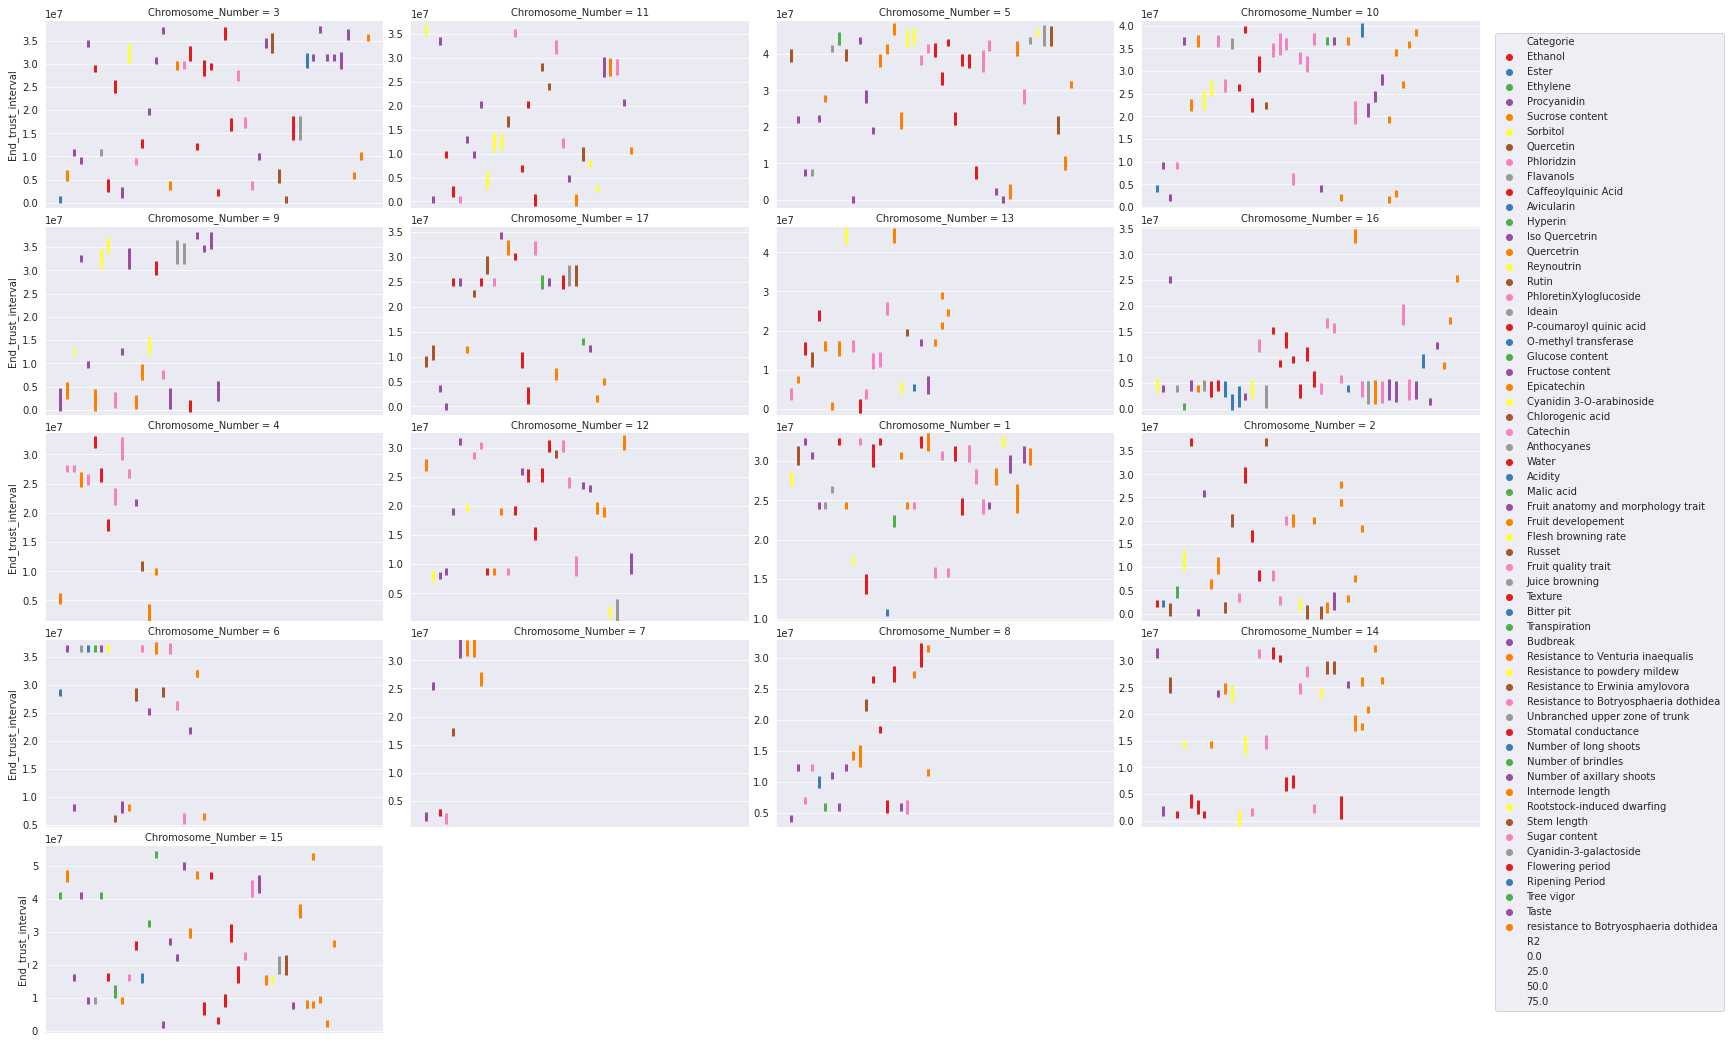

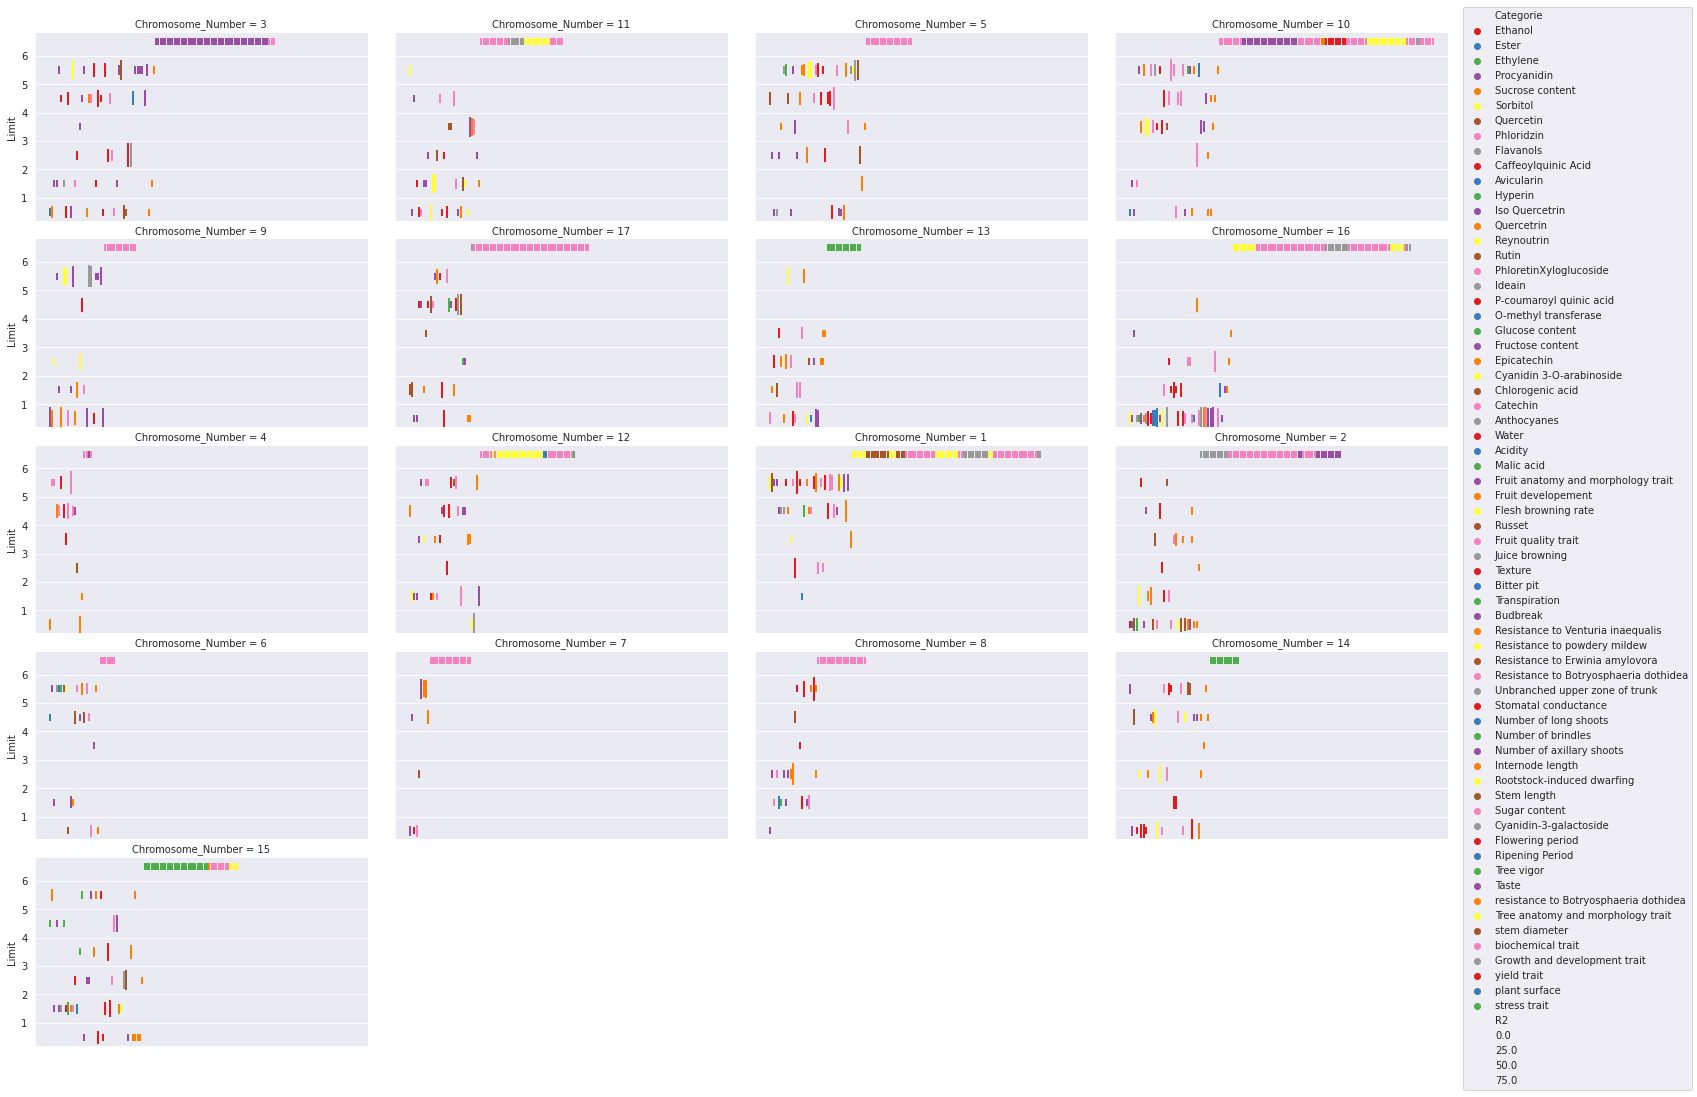

In [10]:
##############################################################################
# Construct visualizations
##############################################################################
colOrder = [3, 11, 5, 10, 9, 17, 13, 16, 4, 12, 1, 2, 6, 7, 8, 14, 15]

generate_visualizations(allQtlDf, allQtlPhysicalyMappedDf, colOrder,
                        outputPathStripplotWithLimits,
                        outputPathStripplotWithPositions)